# 2.2 KNN: Experimentando con activos

En este notebook vamos a volver al ejemplo que hemos visto en la Introducción del curso. Queremos predecir si las acciones de Apple van a subir o bajar a un mes vista a partir de una serie de precios de activos con el algoritmo K-Nearest Neighbors (KNN).

Para ello, vamos a seguir con el ejemplo de la Introducción, es decir, vamos a encontrar patrones similares de comportamiento en las series temporales.

In [75]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

## Descarga de datos y preprocesamiento

In [ ]:
TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "JPM", "NVDA", "V", "UNH", "PG", "HD", "MA", "WMT", "BAC", "ADBE", "NFLX", "META", "TSLA", "JNJ", "WMT", "SPY"]
YEAR_START = 2013
START_DATE = str(YEAR_START)+"-01-01"
data = yf.download(TICKERS, start=START_DATE)
data.head()

[*********************100%%**********************]  19 of 19 completed


Price       Adj Close                                                      \
Ticker           AAPL       ADBE     AMZN       BAC      GOOGL         HD   
Date                                                                        
2013-01-02  16.747723  38.340000  12.8655  9.844127  18.099348  49.084446   
2013-01-03  16.536329  37.750000  12.9240  9.786851  18.109859  48.945271   
2013-01-04  16.075708  38.130001  12.9575  9.909595  18.467718  48.852486   
2013-01-07  15.981153  37.939999  13.4230  9.893226  18.387136  48.589588   
2013-01-08  16.024166  38.139999  13.3190  9.803212  18.350851  48.883415   

Price                                                   ...    Volume  \
Ticker            JNJ        JPM         MA       META  ...      META   
Date                                                    ...             
2013-01-02  51.974960  32.691406  47.666298  27.970324  ...  69846400   
2013-01-03  51.901604  32.625526  47.734509  27.740568  ...  63140600   
2013-01-04  52.495899  33.203812  47.732639  28.729517  ...  72715400   
2013-01-07  52.385826  33.240421  48.559822  29.388819  ...  83781800   
2013-01-08  52.393166  33.306305  48.400002  29.029200  ...  45871300   

Price                                                                   \
Ticker          MSFT      NFLX      NVDA       PG        SPY      TSLA   
Date                                                                     
2013-01-02  52899300  19431300  47883600  9987000  192059000  17922000   
2013-01-03  48294400  27912500  29888800  7741900  144761800  11130000   
2013-01-04  52521100  17761100  52496800  5853700  116817700  10110000   
2013-01-07  37110400  45550400  61073200  5269800  110002500   6630000   
2013-01-08  44703100  24714900  46642400  7362000  121265100  19260000   

Price                                     
Ticker           UNH         V       WMT  
Date                                      
2013-01-02   5358100  15826400  31172400  
2013-01-03  14413200  14937200  26730300  
2013-01-04  10458000  10376000  19314000  
2013-01-07   7804500  10242400  18604200  
2013-01-08   8196200  11800400  17600700  

[5 rows x 114 columns]

In [ ]:
precios = data["Adj Close"]
precios.head()

Ticker,AAPL,ADBE,AMZN,BAC,GOOGL,HD,JNJ,JPM,MA,META,MSFT,NFLX,NVDA,PG,SPY,TSLA,UNH,V,WMT
Date,,,,,,,,,,,,,,,,,,,
2013-01-02,16.747723,38.340000,12.8655,9.844127,18.099348,49.084446,51.974960,32.691406,47.666298,27.970324,22.532856,13.144286,2.935841,49.835754,119.121887,2.357333,45.892815,35.874546,18.145231
2013-01-03,16.536329,37.750000,12.9240,9.786851,18.109859,48.945271,51.901604,32.625526,47.734509,27.740568,22.230995,13.798571,2.938149,49.519737,118.852768,2.318000,43.747124,35.902252,18.029919
2013-01-04,16.075708,38.130001,12.9575,9.909595,18.467718,48.852486,52.495899,33.203812,47.732639,28.729517,21.814936,13.711429,3.035087,49.620274,119.374680,2.293333,43.831257,36.195480,18.098059
2013-01-07,15.981153,37.939999,13.4230,9.893226,18.387136,48.589588,52.385826,33.240421,48.559822,29.388819,21.774137,14.171429,2.947381,49.282742,119.048531,2.289333,43.831257,36.454067,17.925097
2013-01-08,16.024166,38.139999,13.3190,9.803212,18.350851,48.883415,52.393166,33.306305,48.400002,29.029200,21.659929,13.880000,2.882755,49.203747,118.705948,2.245333,43.250656,36.793465,17.974892


Recordad que, aunque no debemos descartar nunca la idea de trabajar con precios, en este caso concreto, para poder comparar activos debemos realizar nuestros cálculos con los retornos.

In [ ]:
retornos = np.log(precios).diff().dropna()
retornos.head()

Ticker,AAPL,ADBE,AMZN,BAC,GOOGL,HD,JNJ,JPM,MA,META,MSFT,NFLX,NVDA,PG,SPY,TSLA,UNH,V,WMT
Date,,,,,,,,,,,,,,,,,,,
2013-01-03,-0.012703,-0.015508,0.004537,-0.005835,0.000581,-0.002839,-0.001412,-0.002017,0.001430,-0.008248,-0.013487,0.048578,0.000786,-0.006361,-0.002262,-0.016826,-0.047883,0.000772,-0.006375
2013-01-04,-0.028250,0.010016,0.002589,0.012464,0.019568,-0.001897,0.011385,0.017570,-0.000039,0.035029,-0.018893,-0.006335,0.032460,0.002028,0.004382,-0.010699,0.001921,0.008134,0.003772
2013-01-07,-0.005899,-0.004995,0.035295,-0.001653,-0.004373,-0.005396,-0.002099,0.001102,0.017181,0.022689,-0.001872,0.032998,-0.029323,-0.006826,-0.002736,-0.001746,0.000000,0.007119,-0.009603
2013-01-08,0.002688,0.005258,-0.007778,-0.009140,-0.001975,0.006029,0.000140,0.001980,-0.003297,-0.012312,-0.005259,-0.020779,-0.022170,-0.001604,-0.002882,-0.019407,-0.013335,0.009267,0.002774
2013-01-09,-0.015752,0.013542,-0.000113,-0.046997,0.006552,-0.000791,0.004472,-0.000660,0.027749,0.051311,0.005634,-0.012949,-0.022673,0.005386,0.002539,-0.001188,0.018696,0.015133,-0.000292


## Definición de un patrón

Para poder encontrar patrones de comportamiento, lo primero que debemos hacer es definir un vector de características.

En este caso, nuestro vector va a estar definido con los retornos del activo en un mes determinado. Hagamos un ejemplo:

Veamos el vector de características de Apple (AAPL) en el mes de octubre de 2021:

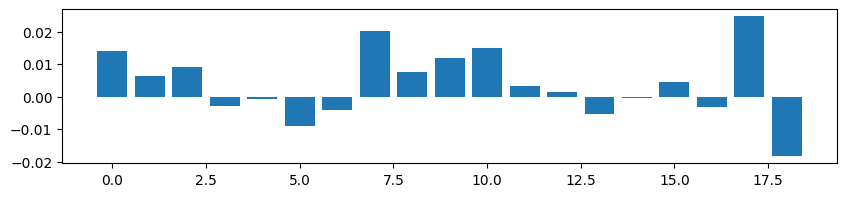

En el mes siguiente a este vector, Apple tuvo una rentabilidad del 9.99 %


In [ ]:
anno_base = 2021
mes_base = 10
fecha = str(anno_base) + "-" + str(mes_base)
fecha_target = str(anno_base) + "-" + str(mes_base+1)
base = retornos.AAPL[fecha].values[-19:]
target = retornos.AAPL[fecha_target].sum()

plt.figure(figsize=(10,2))
plt.bar(range(len(base)), base.T)
plt.show()
print("En el mes siguiente a este vector, Apple tuvo una rentabilidad del", np.around(target*100, decimals=2), "%")

## Predicción

Una vez tenemos el vector de características `base`, nuestro objetivo es encontrar a lo largo del tiempo y de entre todos los activos que estamos estudiando, aquellos K vectores más próximos con la siguiente hipótesis:

**Voy a asumir que aquellos activos que más se parezcan a mí hoy, se van a comportar como yo el mes que viene**

Como KNN utiliza la distancia euclídea para encontrar patrones cercanos, vamos a utilizar este algoritmo. Para ello, tenemos que construir un dataset con la información de todas las ventanas que queramos utilizar.

In [ ]:
datos_x = []
datos_y = []
datos_dict = {}

for anno in range(YEAR_START, anno_base+1):
  mes_max = mes_base if anno == anno_base else 13 ### OJO: Siempre tengo que buscar en el pasado para predecir bien
  for mes in range(1, mes_max):
    fecha = str(anno) + "-" + str(mes)
    fecha_target = str(anno+1) + "-01" if mes == 12 else str(anno) + "-" + str(mes+1)
    for activo in TICKERS:
      vector = retornos[activo][fecha].values[-19:]
      target = retornos[activo][fecha_target].sum()
      datos_x.append(vector)
      datos_y.append(target)
      datos_dict[len(datos_x)-1] = (activo, fecha)
datos_x = np.array(datos_x)
datos_y = np.array(datos_y)
datos_x.shape, datos_y.shape

((2100, 19), (2100,))

Una vez hemos construido el dataset, es tan sencillo como utilizar la clase KNeighborsClassifier de sklearn.

In [57]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(datos_x, datos_y > 0)

# Queremos saber si nuestro vector base va a subir o bajar al mes siguiente habiendo
# mirado los 5 vecinos más cercanos.
knn.predict(base[None, :])

array([ True])

In [ ]:
# El método kneighbors te permite saber las distancias mínimas y el índice de los datos
knn.kneighbors(base[None, :])

(array([[0.03484972, 0.03905883, 0.03937718, 0.03938825, 0.03990922]]),
 array([[ 341,  910, 1997, 1087,  359]]))

In [ ]:
# Utilizando kneighbors y el diccionario que hemos creado, podemos recuperar los activos
# y las fechas
for i_vecino in knn.kneighbors(base[None, :])[1][0]:
  print(datos_dict[i_vecino])

('MSFT', '2014-6')
('MA', '2016-10')
('JNJ', '2021-4')
('UNH', '2017-7')
('SPY', '2014-6')


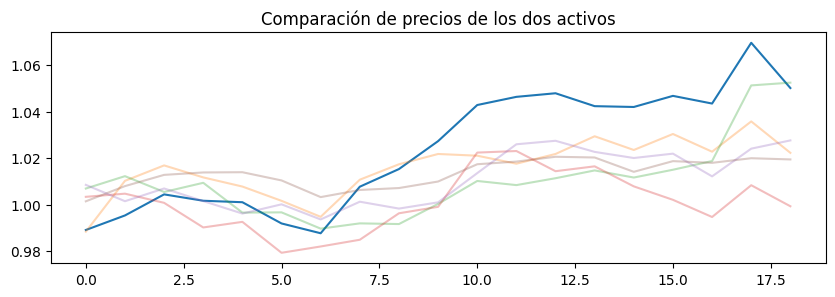

In [ ]:
plt.figure(figsize=(10, 3))
plt.title("Comparación de precios de los dos activos")
plt.plot(range(19), (precios.AAPL["2021-10"]/precios.AAPL["2021-10"].iloc[0])[-19:])
for i_vecino in knn.kneighbors(base[None, :])[1][0]:
  ticker, fecha = datos_dict[i_vecino]
  plt.plot(range(19), (precios[ticker][fecha]/precios[ticker][fecha].iloc[0])[-19:], alpha=0.3)
plt.show()

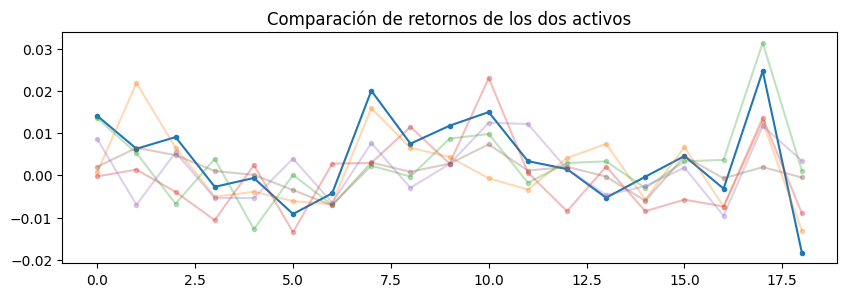

In [ ]:
plt.figure(figsize=(10, 3))
plt.title("Comparación de retornos de los dos activos")
plt.plot(range(19), (retornos.AAPL["2021-10"])[-19:], '.-')
for i_vecino in knn.kneighbors(base[None, :])[1][0]:
  ticker, fecha = datos_dict[i_vecino]
  plt.plot(range(19), (retornos[ticker][fecha])[-19:], '.-', alpha=0.3)
plt.show()

## Construcción de nuestro algoritmo

Siguiendo la hipotesis de que **asumir que aquellos K activos que más se parezcan a mí hoy, se van a comportar como yo el mes que viene**, vamos a intentar predecir el valor de Apple desde enero de 2020 hasta diciembre de 2023.

**Observación**: Recuerda que siempre hay que predecir a futuro con datos hasta la fecha, nunca podemos parecernos a alguien que aún no ha existido.

**Observación 2**: Si K=1, volvemos a hacer el mismo cálculo que hicimos en el notebook 1.1 Introducción.

In [58]:
ticker = "AAPL"
K = 3

targets = []
targets_real = []
preds = []
for anno_base in range(2020, 2024):
  for mes_base in range(1, 13):
    fecha_base = str(anno_base) + "-" + str(mes_base)
    print(fecha_base)
    base = retornos[ticker][fecha_base].values[-19:]
    if mes_base == 12:
      fecha_base_target = str(anno_base+1) + "-01"
    else:
      fecha_base_target = str(anno_base) + "-" + str(mes_base+1)
    target = retornos[ticker][fecha_base_target].sum()
    targets.append(target>0)
    targets_real.append(target)

    datos_x = []
    datos_y = []
    datos_dict = {}

    for anno in range(YEAR_START, anno_base+1):
      mes_max = mes_base if anno == anno_base else 13 ### OJO: Siempre tengo que buscar en el pasado para predecir bien
      for mes in range(1, mes_max):
        fecha = str(anno) + "-" + str(mes)
        fecha_target = str(anno+1) + "-01" if mes == 12 else str(anno) + "-" + str(mes+1)
        for activo in TICKERS:
          vector = retornos[activo][fecha].values[-19:]
          target = retornos[activo][fecha_target].sum()
          datos_x.append(vector)
          datos_y.append(target)
          datos_dict[len(datos_x)-1] = (activo, fecha)
    datos_x = np.array(datos_x)
    datos_y = np.array(datos_y)

    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(datos_x, datos_y > 0)
    pred = knn.predict(base[None, :])[0]
    preds.append(pred)

2020-1
2020-2
2020-3
2020-4
2020-5
2020-6
2020-7
2020-8
2020-9
2020-10
2020-11
2020-12
2021-1
2021-2
2021-3
2021-4
2021-5
2021-6
2021-7
2021-8
2021-9
2021-10
2021-11
2021-12
2022-1
2022-2
2022-3
2022-4
2022-5
2022-6
2022-7
2022-8
2022-9
2022-10
2022-11
2022-12
2023-1
2023-2
2023-3
2023-4
2023-5
2023-6
2023-7
2023-8
2023-9
2023-10
2023-11
2023-12


In [59]:
preds = np.array(preds)
targets = np.array(targets)
targets_real = np.array(targets_real)

Veamos ahora qué resultados obtenemos con nuestra estrategia. Calculemos el accuracy (porcentaje de acierto).

In [60]:
print(" > ACCURACY:", np.mean(preds == targets))

 > ACCURACY: 0.5833333333333334


Hagamos una sencilla simulación, asumiendo que no hay gastos de gestión.

- Cuando predecimos que va a subir, invertimos todo nuestro dinero en Apple.

- Cuando predecimos que va a bajar, vendemos todas nuestras acciones de Apple.

In [61]:
DINERO_INI = 1000
dinero = DINERO_INI
for pred, target in zip(preds, targets_real):
  if pred == True: # Va a subir
    dinero = dinero + dinero * target
  else: # Va a bajar
    dinero = dinero
print(dinero)

1821.366737143273


In [62]:
rent = (dinero - DINERO_INI) / DINERO_INI * 100
print(" > Rentabilidad a cuatro años:", np.around(rent, decimals=2), "%")
print(" > Rentabilidad anual:", np.around(rent/4, decimals=2), "%")

 > Rentabilidad a cuatro años: 82.14 %
 > Rentabilidad anual: 20.53 %


**El resultado es peor que cuando K=1**

Si comparamos con invertir el dinero en Apple en enero del 2020 y dejarlo ahí durante 4 años:

In [63]:
DINERO_INI = 1000
dinero = DINERO_INI
for target in retornos[ticker].resample("M").sum()["2020":"2023"]:
  dinero = dinero + dinero * target
print(dinero)

2237.9801634975333


In [64]:
rent = (dinero - DINERO_INI) / DINERO_INI * 100
print(" > Rentabilidad a cuatro años:", np.around(rent, decimals=2), "%")
print(" > Rentabilidad anual:", np.around(rent/4, decimals=2), "%")

 > Rentabilidad a cuatro años: 123.8 %
 > Rentabilidad anual: 30.95 %


**Hagamos una modificación del algoritmo**

En lugar de utilizar el valor de clasificación True o False, utilicemos el valor real de cada ventana.

In [97]:
ticker = "AAPL"
K = 3

targets = []
targets_real = []
preds = []
preds_real = []
for anno_base in range(2020, 2024):
  for mes_base in range(1, 13):
    fecha_base = str(anno_base) + "-" + str(mes_base)
    print(fecha_base)
    base = retornos[ticker][fecha_base].values[-19:]
    if mes_base == 12:
      fecha_base_target = str(anno_base+1) + "-01"
    else:
      fecha_base_target = str(anno_base) + "-" + str(mes_base+1)
    target = retornos[ticker][fecha_base_target].sum()
    targets.append(target>0)
    targets_real.append(target)

    datos_x = []
    datos_y = []
    datos_dict = {}

    for anno in range(YEAR_START, anno_base+1):
      mes_max = mes_base if anno == anno_base else 13 ### OJO: Siempre tengo que buscar en el pasado para predecir bien
      for mes in range(1, mes_max):
        fecha = str(anno) + "-" + str(mes)
        fecha_target = str(anno+1) + "-01" if mes == 12 else str(anno) + "-" + str(mes+1)
        for activo in TICKERS:
          vector = retornos[activo][fecha].values[-19:]
          target = retornos[activo][fecha_target].sum()
          datos_x.append(vector)
          datos_y.append(target)
          datos_dict[len(datos_x)-1] = (activo, fecha)
    datos_x = np.array(datos_x)
    datos_y = np.array(datos_y)

    # NUEVO: El cambio consiste en entrenar un KNN para regresión en lugar de clasificación
    # weights = "distance" --> closer neighbors of a query point will have a greater influence than neighbors which are further away.
    knn = KNeighborsRegressor(n_neighbors=K, weights="distance")
    knn.fit(datos_x, datos_y)
    pred = knn.predict(base[None, :])[0]
    preds.append(pred > 0)
    preds_real.append(pred)

2020-1
2020-2
2020-3
2020-4
2020-5
2020-6
2020-7
2020-8
2020-9
2020-10
2020-11
2020-12
2021-1
2021-2
2021-3
2021-4
2021-5
2021-6
2021-7
2021-8
2021-9
2021-10
2021-11
2021-12
2022-1
2022-2
2022-3
2022-4
2022-5
2022-6
2022-7
2022-8
2022-9
2022-10
2022-11
2022-12
2023-1
2023-2
2023-3
2023-4
2023-5
2023-6
2023-7
2023-8
2023-9
2023-10
2023-11
2023-12


In [98]:
preds = np.array(preds)
preds_real = np.array(preds_real)
targets = np.array(targets)
targets_real = np.array(targets_real)

In [99]:
print(" > ACCURACY:", np.mean(preds == targets))

 > ACCURACY: 0.625


In [100]:
error = np.sqrt((preds_real - targets_real)**2)
print(" > ERROR CUADRÁTICO PROMEDIO:", np.around(np.mean(error)*100, decimals=2), "% +-", np.around(np.std(error)*100, decimals=2), "%")

 > ERROR CUADRÁTICO PROMEDIO: 7.28 % +- 5.25 %


In [101]:
DINERO_INI = 1000
dinero = DINERO_INI
for pred, target in zip(preds, targets_real):
  if pred == True: # Va a subir
    dinero = dinero + dinero * target
  else: # Va a bajar
    dinero = dinero
print(dinero)

2667.9040495765526


In [102]:
rent = (dinero - DINERO_INI) / DINERO_INI * 100
print(" > Rentabilidad a cuatro años:", np.around(rent, decimals=2), "%")
print(" > Rentabilidad anual:", np.around(rent/4, decimals=2), "%")

 > Rentabilidad a cuatro años: 166.79 %
 > Rentabilidad anual: 41.7 %


**DISCUSIÓN DE LOS RESULTADOS**

- KNN es un buen algoritmo si quieres encontrar similitud entre puntos.

- KNN es sensible a utilizarlo como clasificador o como regresor. Si, como en este caso, estás perdiendo mucha información al decir solo True o False, quizás es una buena opción utilizar una regresión.